# 2.4.2. Обучение нейросетевой модели word2vec.  

Видеоуроки:  
2.4.1. Векторное представление единиц текста.  
**2.4.2. Обучение нейросетевой модели word2vec.**  
2.4.3. Использование обученных моделей RusVectōrēs.  
2.4.4. Нейросетевая модель torch.embedding.  

Дополнительные материалы:  
2.4.5. Использование обученных моделей RusVectōrēs для классификации (анализа тональности) текста.  
2.4.6. Использование моделей Hugging Face для классификации (анализа тональности) текста.  


In [1]:

# all imports in one cell
from typing import List, Dict, Tuple
import numpy as np
import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
from utils import reset_random_seeds
from sklearn.decomposition import PCA
import warnings


In [2]:
# some common settings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
reset_random_seeds(RANDOM_SEED)

> "A word is characterized by the company it keeps"  
[John Rupert Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth)  

**Дистрибутивная гипотеза** - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения (значение слова определяется словами, с которыми оно употребляется).  
Например слова "чай" и "кофе" семантически близки так как употребляются вместе со словами "ложка", "чашка".  
  
**Языковая модель (статистическая)** - распределение вероятностей по последовательностям слов. Нейросетевые модели, обученные предсказывать слово с учетом контекста. Например: "Мама мыла Х", где слово "раму" имеет вероятность больше, чем слово "папу".  
  
**Word2Vec (word to vector)** - нейросетевая языковая модель обучения без учителя, получает на вход слово, на выходе - вектор фиксированной размерности. Задача модели - представить слова таким вектором, чтобы слова со схожим смыслом (контекстом) были близки, а с различающимся - далеки друг от друга.  
Word2Vec обучается на больших объемах текстов (текстах новостей, википедии), что позволяет получить обширные "знания" (языковую интуицию). В результате модель можно переиспользовать на разных задачах.  
  
**Embedding ([вложение](https://ru.wikipedia.org/wiki/Вложение))** - векторное представление слова/текста (результат на выходе из модели).  
  


## Обучение собственной модели  word2vec

Обучим собственную модель на небольшом корпусе текстов. 

### Корпус текстов.

In [6]:
tokenizer = WhitespaceTokenizer()


def delete_punctuation(text: str) -> str:
    """
    Удаление стоп-слов.

    Args:
        text (str): Исходный текст.
    Returns:
        str: Обработанный текст.
    """

    return ' '.join([t for t in tokenizer.tokenize(text) if t not in punctuation])

corpora = [
    'На лугу корова щиплет травку',
    'На лугу овца щиплет травку',
    'Собака ест сухой корм'
    'Кошка ест сухой корм',
]

text_processors = [
    str.lower,
    delete_punctuation,
]

for proc in text_processors:
    for i, text in enumerate(corpora):
        corpora[i] = proc(text)

print(*corpora, sep='\n')

на лугу корова щиплет травку
на лугу овца щиплет травку
собака ест сухой корм
кошка ест сухой корм


### Создание словаря.

Первый шаг обучения модели - создание своего словаря.  
Расширение словаря в модели Word2vec не предусматривается, в "классическом" варианте модель не может работать с несловарнымии словами.  
Для того чтобы обойти это ограничение, можно обучить модель на побуквенных н-граммах (как это сделали [FastText](https://fasttext.cc) )  

In [7]:
tokenized_corpora = [tokenizer.tokenize(text) for text in corpora]
print(tokenized_corpora)

[['на', 'лугу', 'корова', 'щиплет', 'травку'], ['на', 'лугу', 'овца', 'щиплет', 'травку'], ['собака', 'ест', 'сухой', 'корм'], ['кошка', 'ест', 'сухой', 'корм']]


In [8]:
vocabulary = set([tokens for sentence in tokenized_corpora for tokens in sentence])

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

print('word2idx:', word2idx)
print('idx2word:', idx2word)
print('vocabulary_size:', vocabulary_size)

word2idx: {'собака': 0, 'ест': 1, 'травку': 2, 'сухой': 3, 'корм': 4, 'лугу': 5, 'на': 6, 'кошка': 7, 'щиплет': 8, 'корова': 9, 'овца': 10}
idx2word: {0: 'собака', 1: 'ест', 2: 'травку', 3: 'сухой', 4: 'корм', 5: 'лугу', 6: 'на', 7: 'кошка', 8: 'щиплет', 9: 'корова', 10: 'овца'}
vocabulary_size: 11


**Дистрибутивная гипотеза** - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения (значение слова определяется словами, с которыми оно употребляется).  
Например слова "чай" и "кофе" семантически близки так как употребляются вместе со словами "ложка", "чашка".  

Нам нужно создать наборы центральных слов (чай и кофе в примере выше) и слов контекста (ложка, чашка).  
Для обучения модели используется искусственно созданный корпус.  
Размер контекстного окна (`N`)- максимальное количество слов до и после центрального. Например для `N=2` для строки "москва столица россии", мы получим следующий набор:  
Для центрального слова `москва` - `['столица', 'россии']`  
Для центрального слова `столица` - `['москва', 'россии']`  
  
На практике (когда модель обучается на объемных корпусах) такая обработка производится на лету, мы же сделаем этот шаг отдельно.  

In [22]:
cw_size = 2 # context window size - размер контекстного окна
idx_pairs = []

for sentence in tokenized_corpora:
    indices = [word2idx[word] for word in sentence]
    # рассматриваем каждое слово как центральное
    for center_word_i in range(len(indices)):
        # для каждой позиции окна
        for w in range(-cw_size, cw_size + 1):
            context_word_i = center_word_i + w
            if (context_word_i >= 0
                and context_word_i < len(indices)
                and center_word_i != context_word_i):
                context_word_idx = indices[context_word_i]
                idx_pairs.append((indices[center_word_i], context_word_idx))

# для удобства переведем в numpy.array
idx_pairs = sorted(idx_pairs, key=lambda v : v[0])
idx_pairs = np.array(idx_pairs)

In [23]:
print('center', 'context', sep='\t')
for p in idx_pairs[:10]:
    print(*[idx2word[i] for i in p], sep='\t')

center	context
собака	ест
собака	сухой
ест	собака
ест	сухой
ест	корм
ест	кошка
ест	сухой
ест	корм
травку	корова
травку	щиплет



Используются 2 архитектуры нейронных сетей - CBOW (Continuous Bag Of Word) и Skip-gram.  
  
## CBOW (Continuous Bag Of Word)  
Получить самое вероятное центральное слово при условии заданного контекста.  
$P(center|context, \theta)$  
Получить вероятностное распределение для пары "центральное слово = слово контекста" с некоторым параметром $\theta$ (например $P(москва | столица)$)  

## Skip-gram  
Для заданного центрального слова получить список слов контекста (инверсия CBOW).  
$P(context|center, \theta)$  
  
Мы будем реализовывать нашу модель на skip-gram. Давайте разберем подробнее.  
Задача - получить максимум для всех пар контекст/центр.  
$max \prod _{center} \prod _{context} P(context|center; \theta)$  
  
Сумма вероятностей = 1, значит вероятность для несуществующих пар контекст/центр будет близка к 0. Нейронные сети минимизирую функцию потерь, а значит нам нужен $\min$, а не $\max$. Применим некоторые трансформации:  
$\min _{\theta} - \log \prod _{center} \prod _{context} P(context | center, \theta)$
  
Заменим произведение логарифмов их суммой ($\log(a * b) = \log(a) + \log(b)$) и поделим на количество пар ($T$).  
$loss = - \frac {1} {T} \sum _{center} \sum _{context} \log P(context|center, \theta)$  
  
  
$P(context|center) = \frac {\exp (u ^{T} _{context} v _{center})} {\sum _{w \in vocab} \exp(u ^{T} _{w} v _{center})}$  
  
где:  
$\frac {\exp(.)} {\sum \exp(.)}$ - softmax  
  
$u ^{T} _{context} v _{center}$ - скалярное произведение векторов центрального ($v$) и контекстного ($u$) слов.  
  
$\sum _{w \in vocab}$ - итерация по всему словарю  
  
$u ^{T} _{w} v _{center}$ - вычисление сходства для заданного центрального слова и каждого слова словаря (использованного как слово контекста).  
  
Для каждой пары центр/контекст мы вычисляем оценку близости и делим на сумму всех возможных оценок близости заданного центрального слова и всех слов словаря (для определения относительной величины оценки близости в числителе). Softmax гарантирует что значения будут находиться в диапазоне от 0 до 1.  


Схематично CBOW и Skip-gram можно представить так:  
![CBOW vs Skip-gram](https://www.researchgate.net/profile/Nailah-Al-Madi/publication/319954363/figure/fig1/AS:552189871353858@1508663732919/CBOW-and-Skip-gram-models-architecture-1.png)

In [24]:
def get_input_layer(word_idx: int,
                    voc_size: int = vocabulary_size
                    ) -> torch.Tensor:
    """
    One-hot кодирование слова.

    Выдает вектор длиной `voc_size`, значения которого равны 0,
    за исключением `word_idx` = 1.

    Args:
        word_idx (int): индекс кодируемого слова
        voc_size: (int, optional): размер словаря.

    Returns:
        torch.Tensor: бинарный вектор.

    """

    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x


get_input_layer(2, 4)

tensor([0., 0., 1., 0.])

In [158]:
# Скрытый слой 
# матрица весов W1 - для вычисления скрытого представления вектора v (центрального слова)
# выдает вектор размером embedding_dims
# матрица W1 имеет размер [embedding_dims, vocabulary_size]
# в каждой колонке W1 хранится вектор для каждого слова из словаря

embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)

# Выходной слой
# должен иметь vocabulary_size нейронов так как он генерирует вероятности для каждого слова словаря.
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)

num_epochs = 150
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)

        # софтмакс
        log_softmax = F.log_softmax(z2, dim=0)

        # функция потерь
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()

        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()

    if epo % 10 == 0:
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 4.672657074867554
Loss at epo 10: 4.268829268228728
Loss at epo 20: 3.9258061069607115
Loss at epo 30: 3.6319922988768667
Loss at epo 40: 3.379357229763021
Loss at epo 50: 3.1619373499415815
Loss at epo 60: 2.9749384162326655
Loss at epo 70: 2.814166384128233
Loss at epo 80: 2.6757943021754422
Loss at epo 90: 2.5563850173105798
Loss at epo 100: 2.4529698938131332
Loss at epo 110: 2.3630583975464106
Loss at epo 120: 2.2845763446142278
Loss at epo 130: 2.215783189982176
Loss at epo 140: 2.1552042116721473


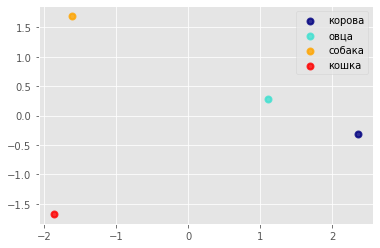

In [159]:
words = 'корова овца собака кошка'.split(' ')
xs = [vectorize(w).detach().tolist() for w in words]
xs_r = PCA(n_components=2).fit(xs).transform(xs)

plt.figure()
colors = ['navy', 'turquoise', 'orange', 'red']
lw = 2

# for color, word in zip(colors, words):
for i, word in enumerate(words):
    color = colors[i]
    plt.scatter(
        xs_r[i][0],
        xs_r[i][1],
        color=color,
        alpha=0.8,
        lw=lw,
        label=word,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()


In [169]:
def similarity(v: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
  """Вычисление меры близости - косинусное расстояние."""

  return torch.dot(v,u) / (torch.norm(v)*torch.norm(u))

In [165]:
def vectorize(word: str) -> torch.Tensor:
    """Получить вектор текста."""
    return torch.matmul(W1, get_input_layer(word2idx[word]))

In [166]:
# {word: [(word, similarity)]}
results: Dict[str, List[Tuple[str, float]]] = {}

words = 'корова овца собака кошка'.split(' ')
for w1 in words:
    results[w1] = []
    for w2 in vocabulary:
        w1v = vectorize(w1)
        w2v = vectorize(w2)
        d = similarity(w1v, w2v).item()
        results[w1].append((w2, d))

    results[w1] = sorted(results[w1], key=lambda item: item[1], reverse=True)

col_width = 15
print(*[c.ljust(col_width) for c in ['Слово', 'Сосед', 'Расстояние']])
print('-'*col_width*3)

for w1 in results:
    for i in range(3):
        d = round(results[w1][i][1], 2)
        print(w1.ljust(col_width), results[w1][i][0].ljust(col_width), d)
    print()


Слово           Сосед           Расстояние     
---------------------------------------------
корова          корова          1.0
корова          щиплет          0.46
корова          овца            0.2

овца            овца            1.0
овца            сухой           0.67
овца            лугу            0.22

собака          собака          1.0
собака          ест             0.65
собака          на              0.51

кошка           кошка           1.0
кошка           травку          0.85
кошка           на              0.73



In [167]:
w_vects = [vectorize(w) for w in words]
neighbors = []
for v1 in w_vects:
    dist = []
    for v2, w2 in zip(w_vects, words):
        d = similarity(v1, v2).item()
        dist.append((d, w2))
    dist = sorted(dist, key=lambda d: d[0], reverse=True)
    n = dist[1][1]
    neighbors.append(n)

for w, n in zip(words, neighbors):
    print(w, n)
    print()

корова овца

овца корова

собака кошка

кошка собака



И выведем на графике несколько слов, предварительно уменьшив размерность векторов слов методом главных компонент:

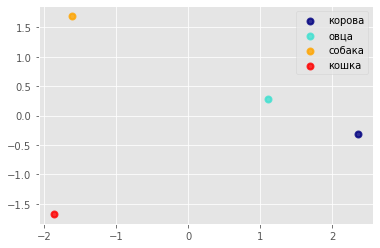

In [170]:
words = 'корова овца собака кошка'.split(' ')
xs = [vectorize(w).detach().tolist() for w in words]
xs_r = PCA(n_components=2).fit(xs).transform(xs)

plt.figure()
colors = ['navy', 'turquoise', 'orange', 'red']
lw = 2

# for color, word in zip(colors, words):
for i, word in enumerate(words):
    color = colors[i]
    plt.scatter(
        xs_r[i][0],
        xs_r[i][1],
        color=color,
        alpha=0.8,
        lw=lw,
        label=word,
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()


# Выводы

1. Модель Word2Vec позволяет представить слово/текст вектором чисел.  
2. Полученный вектор имеет фиксированную размерность и не зависит от размера словаря.  
3. Модель можно обучать на больших корпусах текстов, это позволит переиспользовать одну модель для разных задач (будет рассмотрено в следующих темах).  

# Дополнительные материалы.  
- [Mikolov, T., et al. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781 (2013).](https://arxiv.org/abs/1301.3781)  
- [Mikolov, Tomas, et al. Exploiting similarities among languages for machine translation. arXiv preprint arXiv:1309.4168 (2013).](http://arxiv.org/abs/1309.4168)  